In [1]:
import numpy as np
import raffy.linear_potential as lp
import raffy.utils as ut
from ase.io import read
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error

def mae_force(x, y):
    return np.mean(np.mean(np.sum((x-y)**2, axis = 1)**0.5))

%load_ext autoreload
%autoreload 2

# Transform in FLARE data format

In [2]:
_ = ut.xyz_to_traj("data/Si/train_trajectory.xyz", force_name= 'dft_forces', energy_name = 'DFT_PE')
_ = ut.xyz_to_traj("data/Si/validation_trajectory.xyz", force_name= 'dft_forces', energy_name = 'DFT_PE')

# Load data and prepare dataset

In [3]:
ntr = 100
nval = 100

train_structures = ut.load_structures("data/Si/train_trajectory.json")
val_structures = ut.load_structures("data/Si/validation_trajectory.json")

rand_ind_tr = np.random.choice(np.arange(len(train_structures)), replace = False, size = min(ntr, len(train_structures)))
rand_ind_val = np.random.choice(np.arange(len(val_structures)), replace = False, size = min(nval, len(val_structures)))
X = [train_structures[s] for s in rand_ind_tr]
X_val = [val_structures[s] for s in rand_ind_val]

f_val, e_val = ut.extract_info(X_val)
f_val = ut.reshape_forces(f_val)
f_val = f_val.reshape((len(f_val)//3, 3))
nat_val = np.array([x.nat for x in X_val])

species = [x.coded_species.tolist() for x in X]
species = list(set([item for sublist in species for item in sublist]))

In [38]:
from flare.env import AtomicEnvironment

dists  = [AtomicEnvironment(train_structures[0], i, {'twobody': 3.5}).bond_array_2[:, 0] for i in range(train_structures[0].nat)]
dists = np.array([item for sublist in dists for item in sublist])

In [39]:
from scipy.stats import gaussian_kde

t = np.linspace(1.5, 3.5, 100)
cut = t[np.argmax(gaussian_kde(dists)(t))]*1.75
cut

4.993686868686869

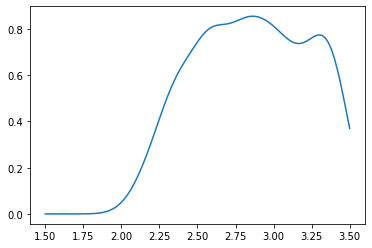

In [40]:
plt.plot(t, gaussian_kde(dists)(t))

# Initialize Linear Potential

In [4]:
ns = 4
ls = 4
r_cut = 5.2

pot = lp.LinearPotential('3', ns, ls, r_cut, species, True, basis = 'scaled_chebyshev')

# Train Linear Potential

In [5]:
pot.fit(X, ncores = 2)

2021-05-06 12:53:17,142	INFO services.py:1090 -- View the Ray dashboard at http://127.0.0.1:8265


# Validate Linear Potential

MAE  FORCE VECTOR: 0.2175 eV/A
RMSE FORCE COMPONENTS: 0.1599 eV/A


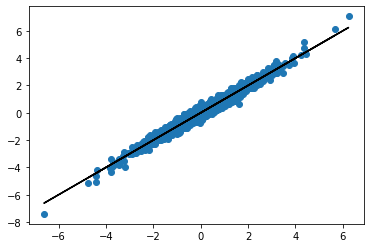

RMSE ENERGY: 0.0081 eV/atom


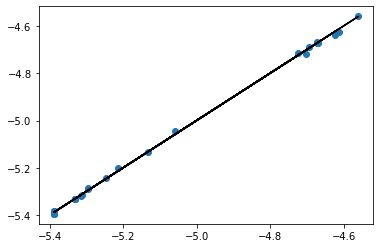

In [6]:
e_hat, f_hat = pot.predict(X_val)

plt.scatter(f_val, f_hat)
plt.plot(f_val, f_val, 'k-')
print("MAE  FORCE VECTOR: %.4f eV/A" %(mae_force(f_val, f_hat)))
print("RMSE FORCE COMPONENTS: %.4f eV/A" %(mean_squared_error(f_val, f_hat)**0.5))
plt.show()


plt.scatter(e_val/nat_val, e_hat/nat_val)
plt.plot(e_val/nat_val, e_val/nat_val, 'k-')
print("RMSE ENERGY: %.4f eV/atom" %(mean_squared_error(e_val/nat_val, e_hat/nat_val)**0.5))
plt.show()